In [1]:
# Firstly, some imports
#Probably can delete some TODO check

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon, Point

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

Dimension of the area is 249870 x 171656 m2


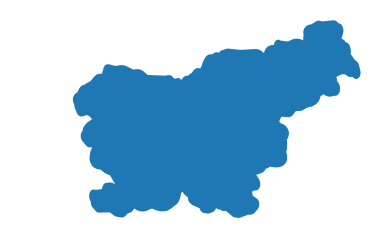

In [2]:
# Load geojson file
country = gpd.read_file('./geojson/svn_buffered.geojson')

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [3]:
country_shape = country.geometry.values.tolist()[-1]

In [4]:
country_shape.bounds

(370230.5261411405, 5024718.807260214, 620100.3316429297, 5196374.997444821)

In [5]:
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

In [6]:
height_pix

17165

In [7]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25*3, 17*3))

In [8]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

In [9]:
if not os.path.isdir('./tile-def'):
    os.makedirs('./tile-def')
    
with open('./tile-def/slovenia_buffered_bbox_32633_17x25_293.pickle','wb') as fp:
    pickle.dump(bbox_splitter, fp)

In [10]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

In [11]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head(2)

,index_x,index_y,geometry
0,0,27,"POLYGON ((370230.5261411405 5115595.613828535,..."
1,0,28,"POLYGON ((370230.5261411405 5118961.421479214,..."


(357737.03586605104, 632593.8219180192, 5016135.997750983, 5204957.806954052)

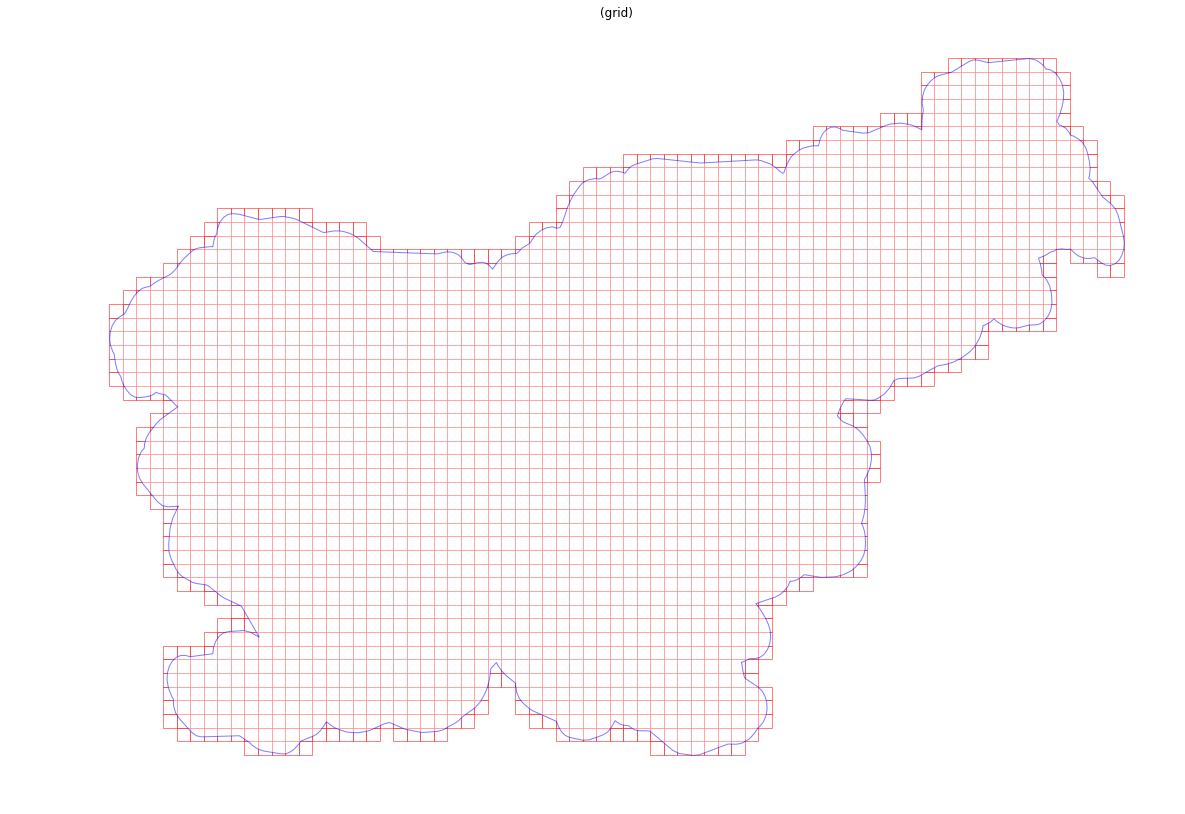

In [12]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('(grid)');
plt.axis('off')

In [13]:
#bbox_list

## Load Sentinel data and save tasks

In [14]:
#custom_script = 'return [B02];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'bands'), # save under name 'BANDS'
    #custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.30, # maximum allowed cloud cover of original ESA tiles
)

path_out = '.\\eopatches\\'
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


In [15]:
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

Finished loading model, total used 170 iterations


In [16]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [17]:
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# Land cover data from http://rkg.gov.si/GERK/

In [18]:
%%time
path = '.\\raba_data\\RABA_20190103.shp'
land_cover = gpd.read_file(path)

Wall time: 2min 18s


In [19]:
land_cover.crs = {'init': 'epsg:3794'}

In [20]:
%%time
land_cover = land_cover.to_crs({'init': 'epsg:32633'})

Wall time: 7min 11s


In [21]:
land_cover.crs

{'init': 'epsg:32633'}

## Land cover load task

In [22]:
land_cover_val = [1100,1160,1180,1190,1211,1212,1221,
                  1222,1230,1240,1300,1321,1410,1420,
                  1500,1600,1800,2000,3000,4100,4210,
                  4220,5000,6000,7000]
land_cover_array = []
for val in land_cover_val:
    temp = land_cover[land_cover.RABA_ID == val]
    temp.reset_index(drop=True, inplace=True)
    land_cover_array.append(temp)
    del temp
    FeatureType.MASK
    
rshape = (FeatureType.MASK, 'IS_DATA')

land_cover_task_array = []
for el, val in zip(land_cover_array, land_cover_val):
    land_cover_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'land_cov'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint32))

# Weather

In [23]:
dfw = pd.read_json('.//weather_data//bb_store_points.json')

In [24]:
dfw.head(2)

,id,lat,lon,shortTitle
0,0,46.432439,14.059292,BB JESENICE
1,1,46.669793,16.178117,BB MURSKA SOBOTA


In [25]:
geometry = [Point(xy) for xy in zip(dfw.lon, dfw.lat)]
#dfw = gdfw.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdfw = gpd.GeoDataFrame(dfw, crs=crs, geometry=geometry)
gdfw = gdfw.drop(['lon', 'lat'], axis=1)

In [26]:
gdfw = gdfw.to_crs({'init': 'epsg:32633'})

In [27]:
gdfw.head(2)

,id,shortTitle,geometry
0,0,BB JESENICE,POINT (427728.4924999267 5142526.130806442)
1,1,BB MURSKA SOBOTA,POINT (590116.9801121651 5169144.432946276)


(357737.03586605104, 632593.8219180192, 5016135.997750983, 5204957.806954052)

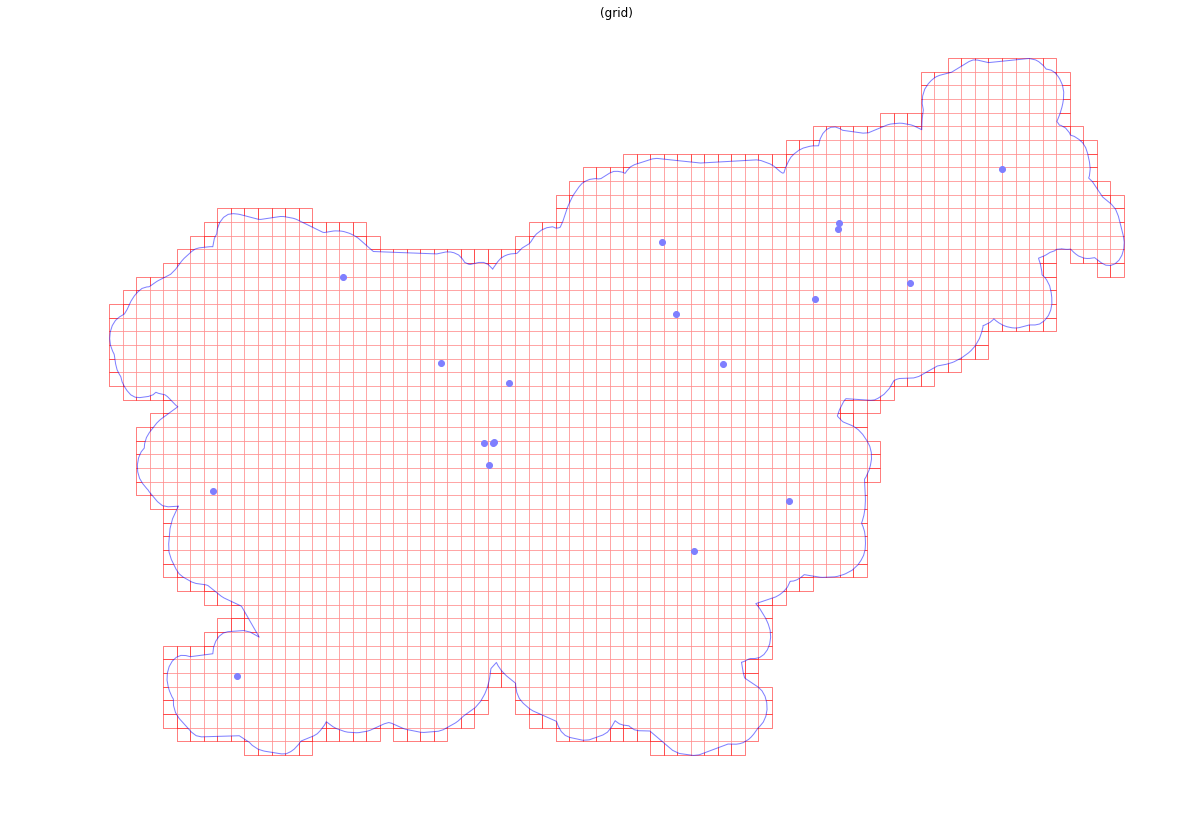

In [28]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
gdfw.plot(ax=ax, facecolor='b',edgecolor='b',alpha=1)
country.plot(ax=ax,facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('(grid)');
plt.axis('off')

## Voronoi

In [112]:
dfw = pd.read_json('.//weather_data//bb_store_points.json')

In [168]:
dfw = pd.read_json('.//weather_data//coordinate.json')

In [169]:
dfw.head(2)

,id,lat,lon
0,0,47.0,13.25
1,1,47.0,13.50


In [191]:
try:
    _dfw = dfw.drop(['id', 'shortTitle'], axis = 1)[['lon', 'lat']]
except:
    _dfw = dfw.drop(['id'], axis = 1)[['lon', 'lat']]
coordinate_array = _dfw.values

In [192]:
dict_coordinates = {}
for i in range(coordinate_array.shape[0]):
    dict_coordinates[str(i)] = coordinate_array[i]

In [193]:
#dict_coordinates

In [194]:
import pytess
voronoi = pytess.voronoi(coordinate_array, buffer_percent = 200)

In [196]:
geometry = []
id_ = []
for i in range(len(voronoi)):
    if voronoi[i][0] is None:
        continue
    geometry.append(Polygon(voronoi[i][1]))
    for key, val in dict_coordinates.items():
        if np.all(val == voronoi[i][0]):
            id_.append(key)

In [197]:
crs = {'init': 'epsg:4326'}
gdf_weather_poly = gpd.GeoDataFrame(id_, crs = crs, geometry = geometry)
gdf_weather_poly = gdf_weather_poly.rename(columns={0: 'id'})
gdf_weather_poly = gdf_weather_poly.to_crs({'init': 'epsg:32633'})

mp = gdf['geometry'].unary_union
gdf_weather_poly['geometry'] = gdf_weather_poly['geometry'].intersection(mp)
gdf_weather_poly.head(2)

,id,geometry
0,106,()
1,118,()


In [198]:
gdf_weather_poly.crs, gdfw.crs, gdf.crs, country.crs

({'init': 'epsg:32633'},
 {'init': 'epsg:32633'},
 {'init': 'EPSG:32633'},
 {'init': 'EPSG:32633'})

(357737.03586605104, 632593.8219180192, 5016135.997750983, 5204957.806954052)

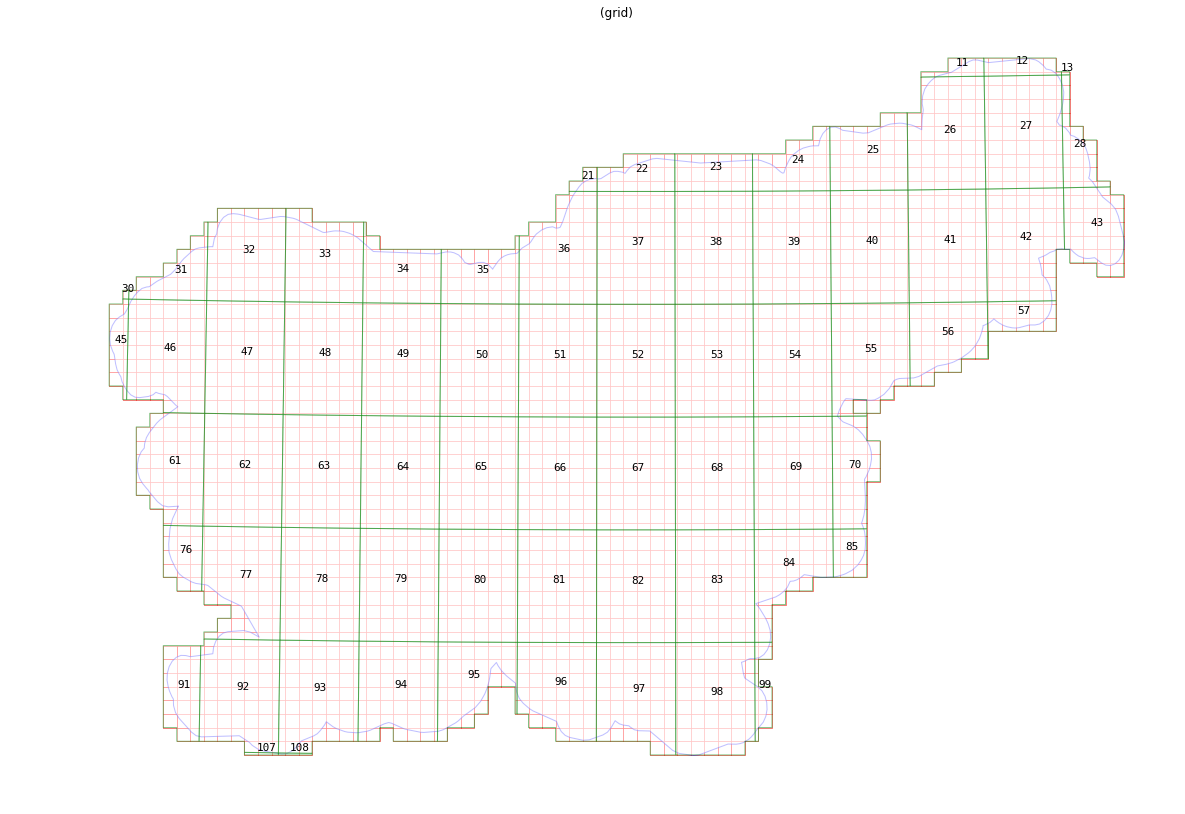

In [199]:
# fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
#gdfw.plot(ax=ax, facecolor='b',edgecolor='b',alpha=1)
country.plot(ax=ax,facecolor='w',edgecolor='b',alpha=0.5)
gdf_weather_poly.plot(ax=ax,facecolor='w',edgecolor='g',alpha=0.5)

for idx in gdf_weather_poly.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    try:
        centroid, = list(gdf_weather_poly.geometry[idx].centroid.coords)
        ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(gdf_weather_poly['id'][idx]), fontdict=fontdict)
    except:
        pass
        #print('{} is not in Slovenia'.format(gdf_weather_poly['id'][idx]))
ax.set_title('(grid)')
plt.axis('off')

# Weather data

In [40]:
df_all = pd.DataFrame()

for i in range(12):
    df_all = df_all.append(pd.read_csv('weather_data\\weather-slovenia_m' + str(i + 1) + '_y2017_col.tsv', sep = '\t'))
for i in range(12):
    df_all = df_all.append(pd.read_csv('weather_data\\weather-slovenia_m' + str(i + 1) + '_y2018_col.tsv', sep = '\t'))
df = df_all
del df_all
df.head(2)

,timestamp,region,dayOffset,10u,10v,2d,2t,rh,sd,sf,sp,ssr,sund,tcc,tp,vis,ws
0,2017-01-01 00:00:00,0,0,0.315193,0.465891,257.540985,270.840576,35.325921,0.0,0.0,91501.1875,0.0,0.0,0.000046,0.0,24296.949219,0.562495
1,2017-01-01 00:00:00,1,0,1.908943,-0.335867,263.854950,267.475830,75.612339,0.0,0.0,100121.1875,0.0,0.0,0.833466,0.0,25050.324219,1.938265


In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date

In [42]:
num_of_areas = coordinate_array.shape[0]

In [43]:
df_list = []
for i in range(num_of_areas):
    df_list.append(df[(df.region == i) & (df.dayOffset == 0)].set_index('timestamp'))

In [44]:
df_list[0].head(1)

,region,dayOffset,10u,10v,2d,2t,rh,sd,sf,sp,ssr,sund,tcc,tp,vis,ws
timestamp,,,,,,,,,,,,,,,,
2017-01-01,0,0,0.315193,0.465891,257.540985,270.840576,35.325921,0.0,0.0,91501.1875,0.0,0.0,0.000046,0.0,24296.949219,0.562495


In [45]:
df_list[0].shape

(5840, 16)

### Calculate aditional weather features

### GeoDataFrame

In [46]:
gdf_list = []
for i in range(coordinate_array.shape[0]):
    gdf_list.append(gpd.GeoDataFrame(df_list[i], crs={'init': 'epsg:32633'}))


#average ower one day
for i in range(coordinate_array.shape[0]):
    #gdf_list[i].set_index('timestamp')
    gdf_list[i] = gdf_list[i].groupby(gdf_list[i].index).mean().drop('dayOffset', axis=1)
    #gdf_list[i].reset_index(level=0, inplace=True)
    #gdf_list[i].rename(columns={'timestamp': 'TIMESTAMP'})
    gdf_list[i] = gpd.GeoDataFrame(gdf_list[i], crs={'init': 'epsg:32633'})

In [47]:
_geometry = gdf_weather_poly.set_index('id')

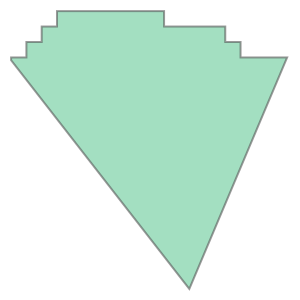

In [48]:
_geometry.loc[str(0),'geometry']

In [49]:
for i in range(coordinate_array.shape[0]):
    gdf_list[i]['geometry'] = _geometry.loc[str(i),'geometry']
    gdf_list[i].reset_index(level=0, inplace=True)

In [50]:
type(gdf_list[0])

geopandas.geodataframe.GeoDataFrame

In [51]:
gdf_list[1].head(1)

,timestamp,region,10u,10v,2d,2t,rh,sd,sf,sp,ssr,sund,tcc,tp,vis,ws,geometry
0,2017-01-01,1,0.786671,1.204387,263.144918,269.998535,61.775543,0.0,0.0,99598.59375,2.504677e+06,13335.763672,0.189386,0.0,24912.244629,2.073684,"POLYGON ((595043.9905662826 5129058.844431249,..."


In [52]:
weather_all_data = gpd.GeoDataFrame(pd.concat(gdf_list,
                                              sort=False,
                                              ignore_index=True), 
                                    crs=gdf_list[0].crs)

# Weather data tasks

In [53]:
class WeatherData(EOTask):
    def __init__(self, feature_name):
        self.name = feature_name
        #self.number = area_number
    
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.VECTOR_TIMELESS,
                            self.name,
                            weather_all_data)
        
        eopatch.add_feature(FeatureType.SCALAR_TIMELESS,
                            'timestamp_{}'.format(self.name),
                            df_list[0].index.values)
        return eopatch

In [54]:
df_list[0].index.values

array([datetime.date(2017, 1, 1), datetime.date(2017, 1, 1),
       datetime.date(2017, 1, 1), ..., datetime.date(2018, 12, 31),
       datetime.date(2018, 12, 31), datetime.date(2018, 12, 31)],
      dtype=object)

In [55]:
add_weather_data = WeatherData(feature_name = 'weather')

In [56]:
add_weather_data

In [57]:
#add_weather_data = WeatherData('weather_data', 1)

## Task

In [58]:
weather_val = []
for i in range(len(gdf_weather_poly)):
    weather_val.append(i);

In [59]:
weather_array = []
for val in weather_val:
    #print(gdf_weather_poly.id)
    #print(val)
    temp = gdf_weather_poly[gdf_weather_poly.id == str(val)]
    temp.reset_index(drop=True, inplace=True)
    weather_array.append(temp)
    del temp
    FeatureType.MASK
    
rshape = (FeatureType.MASK, 'IS_DATA')

weather_area_task_array = []
for el, val in zip(weather_array, weather_val):
    weather_area_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'weather'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint32))

In [60]:
array_w = []
for i in range(num_of_areas):
    array_w.append(np.array([i, gdf_list[i].drop('geometry',1).values]))
array_w = np.array(array_w) 

In [61]:
np.array([array_w[1][1]]).shape

(1, 730, 16)

In [62]:
class AddData(EOTask):
    #does not work
    #data from array if first feeature equal to existing
    #add to  weather
    #data np.array,
    def __init__(self, data, add_to):
        self.data = data
        self.add = add_to
        
    def execute(self, eopatch):
        eopatch.data_timeless[self.add]
        for dat in range(self.data.shape[0]):
            for i in range(eopatch.data_timeless[self.add].shape[0]):
                for j in range(eopatch.data_timeless[self.add].shape[1]):
                    if eopatch.data_timeless[self.add][i][j][0] == self.data[dat][0]:
                        np.insert(eopatch.data_timeless[self.add][i][j], -1, self.data[dat][1])
        return eopatch

In [63]:
array_w

array([[0,
        array([[datetime.date(2017, 1, 1), 0, 0.18820631504058838, ..., 0.0,
        24154.91650390625, 0.6569108402464611],
       [datetime.date(2017, 1, 2), 0, 0.33684206008911133, ..., 0.0,
        23880.292741775513, 0.9029850792107585],
       [datetime.date(2017, 1, 3), 0, -0.28508710861206055, ...,
        5.695223808288574e-05, 23563.123596191406, 0.9243964647490333],
       ...,
       [datetime.date(2018, 12, 29), 0, 0.34352970123291016, ..., 0.0,
        51708.82290649414, 0.6043951385583428],
       [datetime.date(2018, 12, 30), 0, 1.4145952463150024, ...,
        8.054077625274658e-05, 45536.227783203125, 1.6658349833029433],
       [datetime.date(2018, 12, 31), 0, 0.8229997158050537, ...,
        0.00019334256649017334, 40865.24252319336, 1.052770437420992]],
      dtype=object)],
       [1,
        array([[datetime.date(2017, 1, 1), 1, 0.7866712808609009, ..., 0.0,
        24912.24462890625, 2.073683839590433],
       [datetime.date(2017, 1, 2), 1, -0.0885729

In [64]:
add_data_w = AddData(array_w, 'weather')

# Define workfow

In [65]:
#define workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    add_sh_valmask,
    *land_cover_task_array,
    *weather_area_task_array,
    add_weather_data,
    #add_data_w,
    save
)

## Execute

In [95]:
patchIDs = [153, 295, 700, 900, 1445, 1553, 1853, 1965, 2100]

In [96]:
#patchIDs = [1445]

In [97]:
gdf.shape

(2352, 3)

(357737.03586605104, 632593.8219180192, 5016135.997750983, 5204957.806954052)

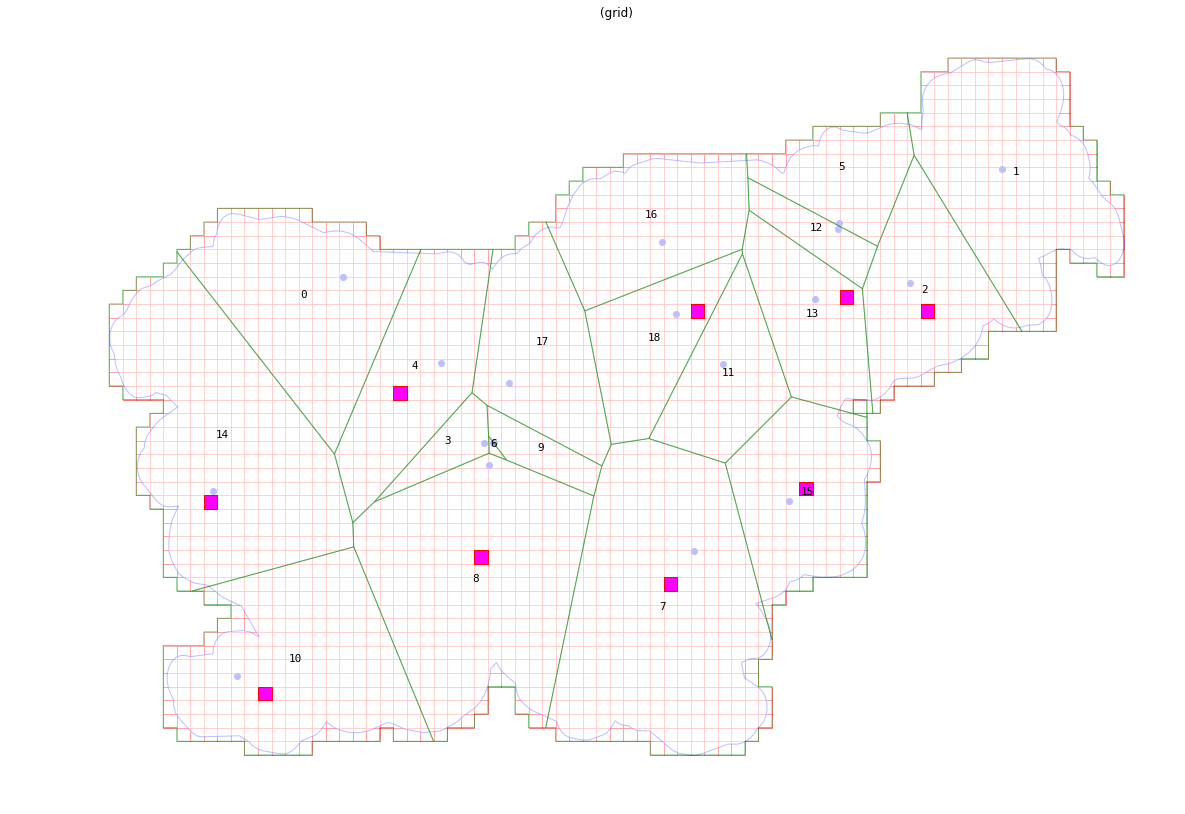

In [98]:
# fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
gdfw.plot(ax=ax, facecolor='b',alpha=1)
country.plot(ax=ax,facecolor='w',edgecolor='b',alpha=0.5)
gdf_weather_poly.plot(ax=ax,facecolor='w',edgecolor='g',alpha=0.5)
gdf.loc[patchIDs].plot(ax=ax,facecolor='magenta',edgecolor='r',alpha=1)

for idx in gdf_weather_poly.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf_weather_poly.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(gdf_weather_poly['id'][idx]), fontdict=fontdict)

ax.set_title('(grid)');
plt.axis('off')

In [99]:
%%time

# Execute the workflow
time_interval = ['2018-01-01', '2018-12-31'] # time interval for the SH request

# Show progress bar 
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(np.array(bbox_list)[patchIDs]): #that
    
    # define additional parameters of the workflow
    extra_param = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }
    
    workflow.execute(extra_param)    
    pbar.update(1)

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

Wall time: 4min 28s


In [70]:
eopatch = EOPatch.load('./eopatches/eopatch_0/')
eopatch.timestamp

[datetime.datetime(2018, 1, 11, 10, 3, 51),
 datetime.datetime(2018, 1, 21, 10, 5, 42),
 datetime.datetime(2018, 1, 24, 10, 13, 52),
 datetime.datetime(2018, 2, 10, 10, 1, 34),
 datetime.datetime(2018, 2, 13, 10, 15, 59),
 datetime.datetime(2018, 2, 28, 10, 10, 21),
 datetime.datetime(2018, 3, 22, 10, 2, 33),
 datetime.datetime(2018, 3, 25, 10, 15, 11),
 datetime.datetime(2018, 4, 6, 10, 2, 43),
 datetime.datetime(2018, 4, 14, 10, 15, 36),
 datetime.datetime(2018, 4, 19, 10, 14, 57),
 datetime.datetime(2018, 4, 21, 10, 4, 27),
 datetime.datetime(2018, 4, 26, 10, 1, 55),
 datetime.datetime(2018, 4, 29, 10, 12, 58),
 datetime.datetime(2018, 5, 6, 10, 2, 14),
 datetime.datetime(2018, 5, 9, 10, 16, 21),
 datetime.datetime(2018, 5, 11, 10, 7, 13),
 datetime.datetime(2018, 5, 19, 10, 12, 7),
 datetime.datetime(2018, 5, 21, 10, 7, 22),
 datetime.datetime(2018, 5, 24, 10, 10, 22),
 datetime.datetime(2018, 5, 26, 10, 5, 53),
 datetime.datetime(2018, 6, 5, 10, 6, 10),
 datetime.datetime(2018, 6,

In [73]:
eopatch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(68, 337, 333, 1), dtype=float32)
    bands: numpy.ndarray(shape=(68, 337, 333, 13), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(68, 337, 333, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(68, 337, 333, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(68, 337, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    land_cov: numpy.ndarray(shape=(337, 333, 1), dtype=uint32)
    weather: numpy.ndarray(shape=(337, 333, 1), dtype=uint32)
  }
  scalar_timeless: {
    timestamp_weather: numpy.ndarray(shape=(5840,), dtype=object)
  }
  label_timeless: {}
  vector_timeless: {
    weather: geopandas.GeoDataFrame(columns=['timestamp', 'region', '10u', '10v', '2d', '2t', 'rh', 'sd', 'sf', 'sp', 'ssr', 'sund', 'tcc', 'tp', 'vis', 'ws', 'geometry'], length=13870, crs=epsg:32633)
  }
  meta_info: {
    maxcc: 0.3
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_d

# Visualize

In [74]:
path_out = '.\\eopatches\\'
eopatch = EOPatch.load('{}eopatch_{}'.format(path_out, 0), lazy_loading=True)
eopatch
img_land = eopatch.mask_timeless['land_cov'].squeeze()
img_land

array([[   0,    0,    0, ..., 2000, 2000, 2000],
       [   0,    0,    0, ..., 2000, 2000, 2000],
       [   0,    0,    0, ..., 2000, 2000, 2000],
       ...,
       [1100, 1100, 1100, ..., 2000, 2000, 2000],
       [1100, 1100, 1100, ..., 2000, 2000, 2000],
       [1100, 1100, 1100, ..., 2000, 2000, 2000]], dtype=uint32)

In [75]:
img_weather = eopatch.mask_timeless['weather'].squeeze()
img_weather 

array([[14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], dtype=uint32)

In [76]:
np.squeeze(eopatch.mask['IS_VALID'][3])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [77]:
np.clip(eopatch.data['bands'][5][..., [2, 1, 0]] * 3.5, 0, 1).shape

(337, 333, 3)

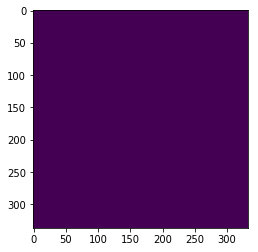

In [78]:
plt.imshow(np.squeeze(eopatch2.mask['CLM'][5]))

In [79]:
np.squeeze(eopatch2.mask['CLM'][4])

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

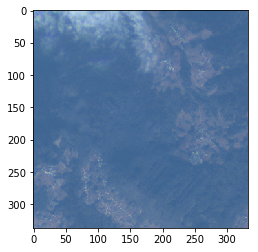

In [90]:
plt.subplot()
plt.imshow(np.clip(eopatch1.data['bands'][0][..., [2, 1, 0]] * 3.5, 0, 1))
#plt.imshow(img_land, alpha = 0.2)

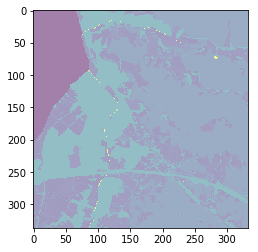

In [81]:
plt.imshow(img_land, alpha = 0.5)

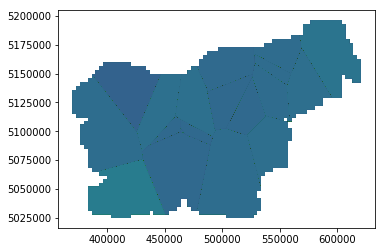

In [82]:
eopatch.vector_timeless['weather'].plot(column = '2t')